# Sample code for processing netcdf4 files for kaggle Solar Energy Prediction Competition.
https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest#description


In [1]:
# A good link to start wrapping your head around netcdf data format: 
# https://www.unidata.ucar.edu/software/netcdf/netcdf-4/newdocs/netcdf-tutorial.html#Intro

# This is a good link describing the dataset for the competition.
# https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/discussion/5057

# It is important to undertsand that the data provided is the *prediction* of a parameter
# (eg. *prediction* of the total precipitation), rather than the *observed* data.
# The data is a dictionary of all the helper/axis variables in it once you load the 
# netcdf4 and the actual data. The actual data is a big array of shape (5113, 11, 5, 9, 16) 
# with 5113 daily predictions from 1994 to 2007, 11 ensemble members of the GEFS 
# (different submodel predictions I think), 5 actual predictions (it's released at midnight 
# I think so it's forcast for 12, 15, 18, 21, and 24 hours out), and 9 latitudes and 16 
# longitudes for where the predictions are spatially.
# The GEFS is a weather model that just predicts various things at various locations, 
# and the data is those predictions.

# A good python code sample if you prefer a hacker's approach:
# http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html


In [2]:
# Installing netcdf4 python library may be non-trivial. The below code is confirmed to work on AWS SageMaker notebook 
# with 'conda python 3' kernel

In [3]:
!conda install -c anaconda netcdf4 --yes
!conda install -y s3fs

from netCDF4 import Dataset

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - netcdf4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h14c3975_0         3.5 MB  anaconda

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.03.07-0      anaconda
    openssl:         1.0.2p-h14c3975_0 --> 1.0.2p-h14c3975_0 anaconda

The following packages will be DOWNGRADED:

    certifi:         2018.11.29-py36_0 --> 2018.10.15-py36_0 anaconda


openssl-1.0.2p       | 3.5 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing 

The easiest (not necessarily the fastest) way to xfer the data to your SageMaker machine is to:
1. download it to your local machine (eg. your laptop)
2. upload the file to your AWS S3 bucket (eg: 3://sergey-ML-workshop) 
3. download the file from AWS S3 bucket to the machine used to host your SageMaker notebook.
    3a. in SageMaker Jupyter console, open a terminal window.
    3b. in the terminal window, issue a command to copy the file to your data directory. Example:
         $cd SageMaker
        $cd <YourProjectDirecotory>
         $mkdir data
        $mkdir data/train
         $cd data/train
        $aws s3 cp s3://sergey-ML-workshop/data.nc .
        
        

In [4]:
dataset = Dataset('/home/ec2-user/SageMaker/data/gefs_train/train/apcp_sfc_latlon_subset_19940101_20071231.nc')
print (dataset.file_format)
print (dataset.dimensions.keys())
print (dataset.dimensions['time'])
print (dataset.variables.keys())
print (dataset.variables['intTime'][5110:])
print (dataset.dimensions['lat'])
print (dataset.variables['lat'][0:])
print (dataset.dimensions['lon'])
print (dataset.variables['lon'][0:])
print (dataset.variables['Total_precipitation'])
print (dataset.variables['Total_precipitation'][0][0][0][0][0])

# per https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest/discussion/5288, 
# The ensemble control run (the first ensemble member) should have the best fit initial 
# conditions for each day. 



NETCDF4
odict_keys(['time', 'lat', 'lon', 'ens', 'fhour'])
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113

odict_keys(['time', 'intTime', 'lat', 'lon', 'ens', 'fhour', 'intValidTime', 'Total_precipitation'])
[2007122900 2007123000 2007123100]
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9

[31. 32. 33. 34. 35. 36. 37. 38. 39.]
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16

[254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267.
 268. 269.]
<class 'netCDF4._netCDF4.Variable'>
float32 Total_precipitation(time, ens, fhour, lat, lon)
    _FillValue: 9999.0
    units: kg m-2
    long_name: Total_precipitation_Accumulation (Accumulation for  Mixed Intervals) @ surface
    cell_methods: time: sum
    GRIB_param_discipline: Meteorological_products
    GRIB_param_category: Moisture
    GRIB_param_name: Total_precipitation
    GRIB_generating_process_type: Forecast
    GRIB_param_id: [2 0 1 8]
    GRIB_product_definition_template: 8


In [90]:
import pandas as pd
solar_output = pd.read_csv("/home/ec2-user/SageMaker/data/train.csv")

In [91]:
solar_output["Date"] = pd.to_datetime(solar_output["Date"], format = "%Y%m%d")
start_date = solar_output["Date"].iloc[0]
end_date = solar_output["Date"].iloc[-1]

solar_output.index = pd.date_range(start_date, end_date, freq='D')
solar_output = solar_output.drop("Date",axis=1)

In [92]:
training = solar_output.iloc[:int(solar_output.shape[0]/10*9)]
testing = solar_output.iloc[int(solar_output.shape[0]/10*9):]
training.to_csv("training_split_9_10ths.csv")
testing.to_csv("testing_split_9_10ths.csv")

In [93]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role
import json

bucket = "forcasting-project-group"
prefix = "forecasting/mvp"

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [133]:
time_series_training = []
for col in training.columns:
    time_series_training.append(training[col])
    
time_series = []
for col in testing.columns:
    time_series.append(testing[col])





In [95]:
encoding = "utf-8"
freq = 'D'
s3filesystem = s3fs.S3FileSystem()

def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [96]:
validation_channel = prefix + '/validation'
train_channel = prefix + '/train'
sess = sagemaker.Session()
sess.upload_data(path='/home/ec2-user/SageMaker/Architecting-For-ML-on-Amazon-SageMaker/Starter-Code/training_split_9_10ths.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='/home/ec2-user/SageMaker/Architecting-For-ML-on-Amazon-SageMaker/Starter-Code/testing_split_9_10ths.csv', bucket=bucket, key_prefix=validation_channel)


's3://forcasting-project-group/forecasting/mvp/validation/testing_split_9_10ths.csv'

In [118]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.18xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)


In [119]:
context_length = 3000
freq = 'D'
prediction_length = len(testing)


hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}
estimator.set_hyperparameters(**hyperparameters)


In [ ]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2018-12-20-18-49-08-170


2018-12-20 18:49:08 Starting - Starting the training job...
2018-12-20 18:49:10 Starting - Launching requested ML instances......
2018-12-20 18:50:18 Starting - Preparing the instances for training......
2018-12-20 18:51:22 Downloading - Downloading input data...
2018-12-20 18:51:51 Training - Training image download completed. Training in progress.
Arguments: train
[12/20/2018 18:51:54 INFO 139988546754368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[12/

In [127]:

job_name = estimator.latest_training_job.name
endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

ValueError: Endpoint with name "DEMO-deepar-2018-12-20-18-49-08-170" already exists; please pick a different name.

In [128]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [129]:

predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [130]:
list_of_df = predictor.predict(time_series[:5])


In [137]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

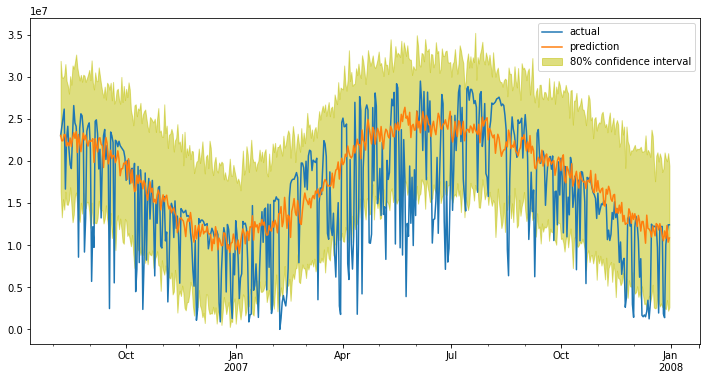

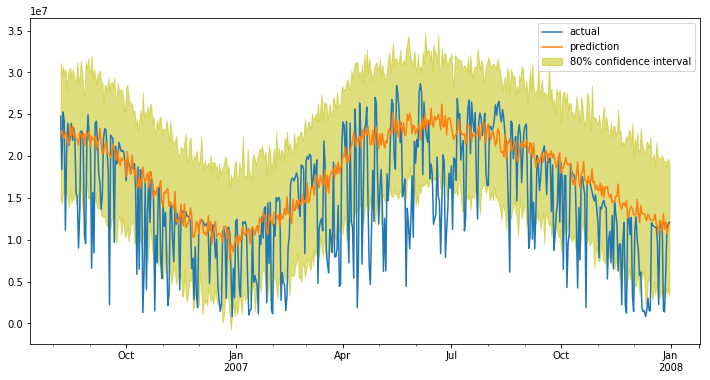

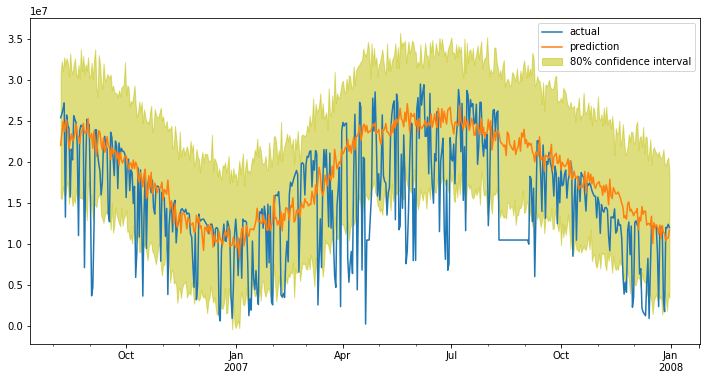

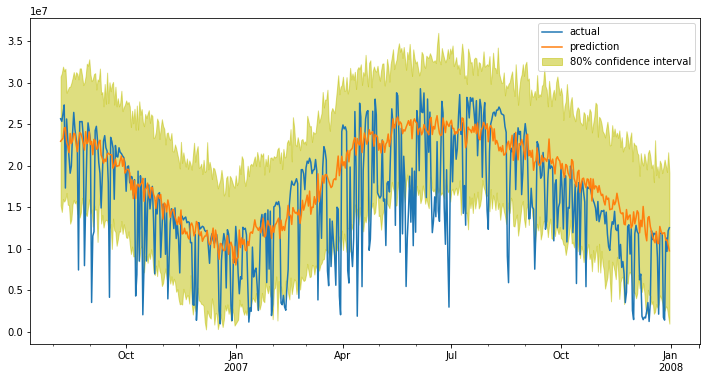

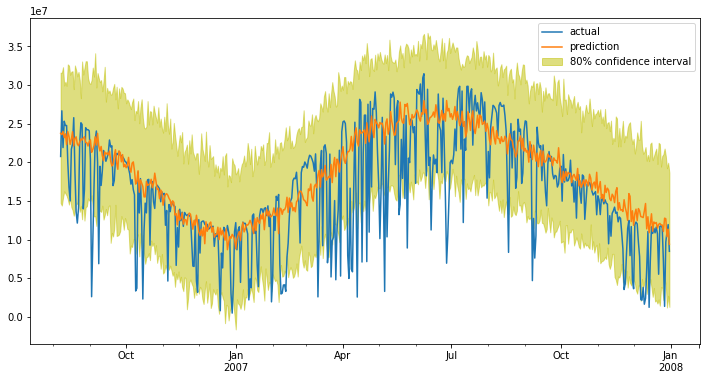

In [141]:
import matplotlib.pyplot as plt
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k].index = pd.to_datetime(actual_data[k].index, format='%Y%m%d')
    actual_data[k][-prediction_length-context_length:].plot(label='actual')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k].index = pd.to_datetime(list_of_df[k].index, format='%Y%m%d')
    list_of_df[k]['0.5'].plot(label='prediction')
    plt.legend()
    plt.show()

In [ ]:
sess.delete_endpoint(endpoint_name)